<a href="https://colab.research.google.com/github/pulavartivinay/Face_Mask_Detection/blob/model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# start

In [2]:
# installs

In [3]:
# imports
import tensorflow as tf
from keras.utils import plot_model
from keras.models import model_from_json
from keras import backend as K
import cv2
from google.colab.patches import cv2_imshow
import glob
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

In [4]:
# loading dataset
# https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

!gdown --id 1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe #loading the dataset from google drive link to colab
!unzip /content/face-mask-12k.zip &> /dev/null #unzipping
!rm -rf /content/face-mask-12k.zip &> /dev/null #deleting the zip file
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe
To: /content/face-mask-12k.zip
351MB [00:02, 120MB/s]


In [29]:
# finding the perfect crop size, for whole dataset
# https://stackoverflow.com/questions/19098104/python-opencv2-cv2-wrapper-to-get-image-size

def generate_image_paths(dir_path):
  files_png = glob.glob(dir_path + '/**/*.png', recursive=True)
  paths = list(files_png)
  return paths

train_dataset_path = "/content/face-mask-12k/Train"
val_dataset_path = "/content/face-mask-12k/Validation"

train_paths = generate_image_paths(train_dataset_path)
val_paths = generate_image_paths(val_dataset_path)

print(len(train_paths)) #output: 10000
print(len(val_paths))   #output: 800

def find_avg_height_and_width(paths):
  sum_height = 0
  sum_width = 0
  for path in paths:
    image = cv2.imread(path)
    height, width, channels = image.shape
    sum_height += height
    sum_width += width
  avg_height = sum_height//len(paths)
  avg_width = sum_width//len(paths)
  return (avg_height, avg_width)

print("Train avg height and width", find_avg_height_and_width(train_paths)) #output: (153, 153)
print("Validation avg height and width", find_avg_height_and_width(val_paths)) #output: (152, 152)

10000
800
Train avg height and width (153, 153)
Validation avg height and width (152, 152)


In [30]:
# hyper parameters
epochs = 2
batch_size = 16

In [31]:
# Preprocessing the data set into list of images
# https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Train",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Validation",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

print("Train-dataset-length", len(train_dataset))
print("Validation-dataset-length", len(val_dataset))

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Train-dataset-length 625
Validation-dataset-length 50


In [32]:
# Adding call Back Functions
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [48]:
# Main Model 

class MModel:
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.model = self.get_model()
    self.train_history = []
    self.val_history = []
    self.test_history = []


  def get_model(self):
    inputs = tf.keras.Input(shape=self.input_shape)  #input layer
    batch_normalization_layer = tf.keras.layers.BatchNormalization()(inputs)
    base_model = tf.keras.applications.Xception(
                weights='imagenet',
                input_shape=self.input_shape,
                include_top=False)(batch_normalization_layer)
    layer1 = tf.keras.layers.Conv2D(
        filters=2,
        kernel_size=4,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(base_model)
    batch_normalization_layer1 = tf.keras.layers.BatchNormalization()(layer1)
    max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(batch_normalization_layer1)
    drop_out_layer1 = tf.keras.layers.Dropout(rate=0.1)(max_pool_2d)
    layer2 = tf.keras.layers.Flatten()(drop_out_layer1)
    batch_normalization_layer2 = tf.keras.layers.BatchNormalization()(layer2)
    Dense_layer1 = tf.keras.layers.Dense(
        64,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(batch_normalization_layer2)
    outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(Dense_layer1)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.summary()
    plot_model(model, to_file='main_model_V040301.png') #convention for the model plot: main_model_VddMMXX where XX is the model number
    return model

  def compile(self, optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def train(self, train_dataset, epochs=1):
    self.train_history = self.model.fit(train_dataset, epochs=epochs, verbose=1)

  def evaluate(self, val_dataset, batch_size="32"):
    self.val_history = self.model.evaluate(val_dataset, batch_size=32, verbose=1)

  def predict_single(self, image):
    """
      image dimensions should be (153, 153, 3)
    """
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    p = self.model.predict(input_arr, verbose = 0)
    return round(p[0][0])

  def plot_loss_per_epoch(self):
    plt.plot(self.train_history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  def plot_accuracy_per_epoch(self):
    plt.plot(self.train_history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  def plot_f1_per_epoch(self):
    plt.plot(self.train_history.history['f1'])
    plt.title('model f1_score')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
  
  def plot_precision_per_epoch(self):
    plt.plot(self.train_history.history['precision'])
    plt.title('model precision_score')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  def plot_recall_per_epoch(self):
    plt.plot(self.train_history.history['recall'])
    plt.title('model recall_score')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  def write_model_with_weights_to_file(self, filepath):
    self.model.save(filepath)

In [49]:
# Creating instance of MModel Class

mmodel = MModel((153, 153, 3))

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 153, 153, 3)]     0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 153, 153, 3)       12        
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 2, 2, 2)           65538     
_________________________________________________________________
batch_normalization_38 (Batc (None, 2, 2, 2)           8         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 2)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 2)           0   

In [50]:
# Model Compilation
# https://keras.io/api/models/model_training_apis/

mmodel.compile()

In [51]:
# Training
# https://keras.io/api/models/model_training_apis/

mmodel.train(train_dataset, epochs=epochs)

Epoch 1/2
625/625 [==============================] - 92s 140ms/step - loss: 0.2431 - acc: 0.9569 - precision_7: 0.9501 - recall_7: 0.9675
Epoch 2/2
625/625 [==============================] - 88s 140ms/step - loss: 0.0576 - acc: 0.9841 - precision_7: 0.9856 - recall_7: 0.9833


In [52]:
# model evaluation on val dataset
# https://keras.io/api/models/model_training_apis/

mmodel.evaluate(val_dataset)

50/50 [==============================] - 3s 48ms/step - loss: 0.0209 - acc: 0.9937 - precision_7: 1.0000 - recall_7: 0.9875


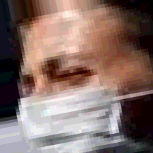

Ground Truth 0.0
Prediction 0


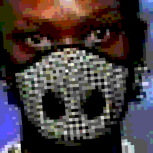

Ground Truth 0.0
Prediction 0


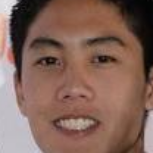

Ground Truth 1.0
Prediction 1


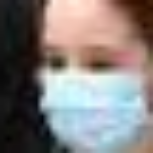

Ground Truth 0.0
Prediction 0


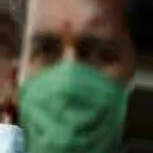

Ground Truth 0.0
Prediction 0


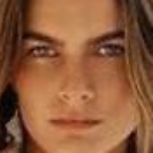

Ground Truth 1.0
Prediction 1


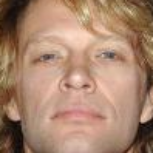

Ground Truth 1.0
Prediction 1


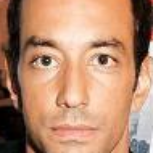

Ground Truth 1.0
Prediction 1


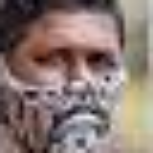

Ground Truth 0.0
Prediction 0


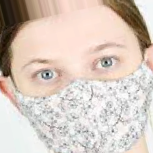

Ground Truth 0.0
Prediction 0


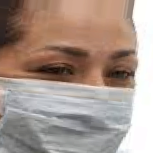

Ground Truth 0.0
Prediction 0


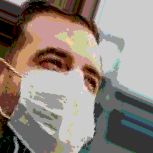

Ground Truth 0.0
Prediction 0


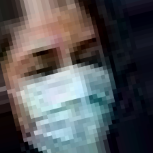

Ground Truth 0.0
Prediction 0


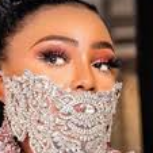

Ground Truth 0.0
Prediction 0


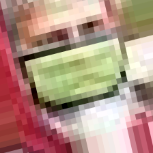

Ground Truth 0.0
Prediction 0


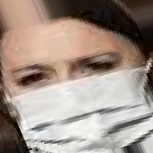

Ground Truth 0.0
Prediction 0


In [53]:
# Predictions of Validation data set(Dev) - visualisation

i = 0
for batch in val_dataset:
  for i in range(batch_size):
    rgb_image = batch[0][i]
    label = batch[1][i].numpy()[0]

    bgr_image = cv2.cvtColor(rgb_image.numpy(), cv2.COLOR_RGB2BGR)
    cv2_imshow(bgr_image)

    print("Ground Truth", label)
    print("Prediction", mmodel.predict_single(rgb_image))
    i+=1
  if i>=10:
    break

In [54]:
mmodel.train_history.history['precision']

KeyError: ignored

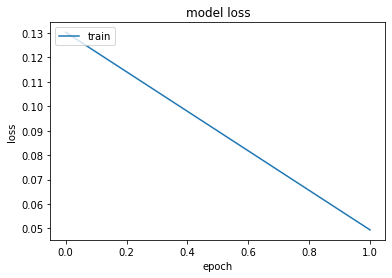

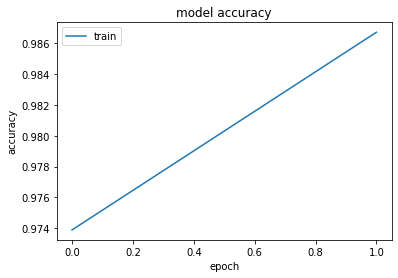

KeyError: ignored

In [55]:
# Drawing the train Loss, accuracy, f1, precision, recall of the model - visualising

mmodel.plot_loss_per_epoch()
mmodel.plot_accuracy_per_epoch()
# mmodel.plot_f1_per_epoch()
mmodel.plot_precision_per_epoch()
mmodel.plot_recall_per_epoch()

In [56]:
# saving model to file

mmodel.write_model_with_weights_to_file('model0.h5')